In [159]:
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10 # Mnist - набор рукописных цифр, cifar10 - изображения объектов 1-ти классов
from tensorflow.keras.layers import Input, concatenate, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, Embedding, multiply # Базовые слои keras
from tensorflow.keras.layers import LeakyReLU # LeakyReLU - функция активации
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose # Сверточные слои keras
from tensorflow.keras.models import Sequential, Model # Формат модели keras
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam # Оптимизатор 
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt # Отображение графиков

import numpy as np # Numpy массивы

In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Настройки

In [161]:
IMAGES_FOLDER = '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/11. Генеративные состязательные сети/files' 
BATCH_SIZE = 10
LATENT_DIM = 128*128*3
INPUT_SHAPE = [128, 128, 3]

## Создаём датасет

In [162]:
img_list = []
label_list = []
for i in range(10):
  # Изображения
  img = image.load_img(
      path = IMAGES_FOLDER + '/' + str(i+1) + '.jpg', 
      color_mode='rgb', 
      target_size=(128, 128),
  )
  img_tensor = image.img_to_array(img)/255
  img_list.append(img_tensor)

  # Лейблы (самолёты)
  lbl = image.load_img(
      path = IMAGES_FOLDER + '/label_' + str(i+1) + '.jpg', 
      color_mode='rgb', 
      target_size=(128, 128),
  )
  label_tensor = image.img_to_array(lbl)/255
  label_list.append(label_tensor)

imgs = np.array(img_list)
labels = np.array(label_list)

print(imgs.shape)
print(labels.shape)

(10, 128, 128, 3)
(10, 128, 128, 3)


## Изображения

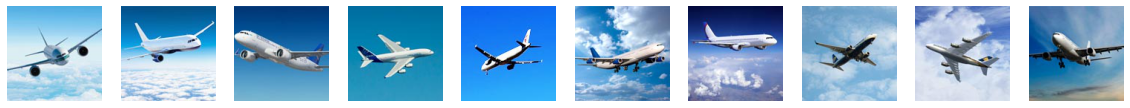

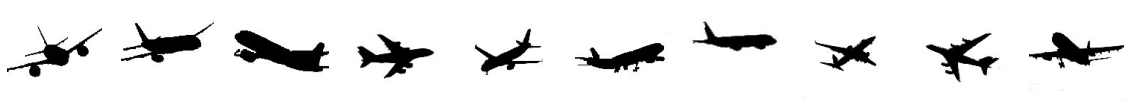

In [163]:
# Самолёты
fig = plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(imgs[i])
  plt.axis('off')
plt.show()

# Лейблы
fig = plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(labels[i])
  plt.axis('off')
plt.show()

In [164]:
NOISE_CONST = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

## Функции отображения

In [165]:
def sample_images(epoch, gen, labels, noise): # Функция печати изображений
  r, c = 1, 10 # Параметры вывода (количество строк (r) и количество столбцов (c))

  # lb = np.expand_dims(labels[0], axis=0)

  gen_imgs = gen.predict([NOISE_CONST, labels[0:10]]) # Предиктим картинку с помощью входной переменной gen
  # gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1
  # gen_imgs = gen_imgs*255


  fig = plt.figure(figsize=(20, 4))
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(gen_imgs[i])
    plt.axis('off')
  plt.show()
  plt.close() # Завершаем работу с plt


def plot_images(x_data): # Функция печати изображений
  plt.figure(figsize=(20, 2))
  for i in range(10):
    plt.subplot(1, 10, i+1) # Выведем область рисования Axes
    plt.xticks([])  # Убираем ось х
    plt.yticks([])  # Убираем ось y
    plt.grid(False)  # Убираем стеку
    plt.imshow(x_data[i].squeeze()) 
    plt.xlabel(i, fontsize=14)

# ======= СВЁРТОЧНАЯ СЕТЬ =======
Попробуем функцию активации relu - это значит, что приведём данные к диапазону 0 - 1 вместо диапазона -1, 1 как в предыдущем примере

# Модели
На вход генератора подаём вектор независимых нормальных величин размерностью LATENT_DIM

In [166]:
g_x_input = Input(shape=(LATENT_DIM))
g_x = Flatten()(g_x_input)
g_y_input = Input(shape=(INPUT_SHAPE))
g_y = Flatten()(g_y_input)
# g = concatenate([g_x, g_y], name='g_concatenate')
g = multiply([g_x, g_y])
g = Dense(1024, activation='relu', name='g_x_1')(g)  # 1024 = 8*8*16
g = Reshape((8, 8, 16))(g)  # 8 x 8 x 16
g = Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', activation='relu')(g)  # 8 x 8 x 16
g = BatchNormalization()(g)
g = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', activation='relu')(g)  # 16 x 16 x 16
g = BatchNormalization()(g)
g = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', activation='relu')(g)  # 32 x 32 x16
g = BatchNormalization()(g)
g = Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', activation='relu')(g)  # 64 x 64 x 8
g = BatchNormalization()(g)
g = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(g)  # 128 x 128 x 3

generator = Model([g_x_input, g_y_input], g, name='generator')


d_x_input = Input(shape=(INPUT_SHAPE))
d_x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=INPUT_SHAPE)(d_x_input)  # 128 x 128 x 3 => 64 x 64 x 32
d_x = LeakyReLU()(d_x)
d_x = Dropout(0.3)(d_x)
d_x = Conv2D(8, (5, 5), strides=(2, 2), padding='same')(d_x)  # 32 x 32 x 8
d_x = LeakyReLU()(d_x)
d_x = Dropout(0.3)(d_x)
d_x = Conv2D(8, (5, 5), strides=(2, 2), padding='same')(d_x)  # 16 x 16 x 8
d_x = LeakyReLU()(d_x)
d_x = Dropout(0.3)(d_x)
d_x = Conv2D(768, (5, 5), strides=(2, 2), padding='same')(d_x)  # 8 x 8 x 768
d_x = LeakyReLU()(d_x)
d_x = Dropout(0.3)(d_x)
d_x = Flatten()(d_x)
d_y_input = Input(shape=(INPUT_SHAPE))
d_y = Flatten()(d_y_input)
# d = concatenate([d_x, d_y], name='d_concatenate')
d = multiply([d_x, d_y])

d = Dense(1)(d)  # Линейная функция активации не имеет областей насыщения

discriminator = Model([d_x_input, d_y_input], d, name='discriminator')

## Функции потерь

In [167]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(fake_output):
  # cross_entropy - BinaryCrossentropy - вычисление бинарной кроссэнтропии, передаём желаемый и реальный отклик сети
  # У генератора желаемый отклик - 1
  # Тензор из '1' равен по длине fake_output
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss


def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Желаемый отклик тензор из '1' для реальных изображений
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Желаемы отклик тензор из '0' для фейковых изображений
  total_loss = real_loss + fake_loss
  return total_loss

## Оптимизаторы

In [168]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Функция шага обучения

In [169]:
d_loss_list = [] # Массив значений ошибки дескриминатора
g_loss_list = [] # Массив значений ошибки генератора
d_acc_list = [] # Массив значений точности модели

@tf.function
def train_step(images, label_bath, noise): # Функция обучения
  # Вычислительные градиенты
  # TensorFlow должен помнить, какие операции в каком порядке выполняются во время прямого прохода. 
  # Затем во время обратного прохода TensorFlow просматривает этот список операций в обратном порядке для вычисления градиентов.
  # TensorFlow «записывает» соответствующие операции, выполняемые в контексте, tf.GradientTapeна «ленту». 
  # Затем TensorFlow использует эту ленту для вычисления градиентов «записанного» вычисления с использованием обратного дифференцирования .

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([noise, label_bath], training=True)

    real_output = discriminator([images, label_bath], training=True)  # Вызываем дескриминатор с реальными изображениями; в объект gen_tape записываются необходимые вычисления
    fake_output = discriminator([generated_images, label_bath], training=True)  # Вызываем дескриминатор с фейковыми изображениями

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Используя объект gen_tape вычисляем градиент для генератора
  # Градиент необходимо вычислять используя функцию потерь gen_loss и для весовых коэффициентов генератора generator.trainable_variables
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  # Используя объект gen_tape вычисляем градиент для дискриминатора
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Применяем вычисленные градиенты к оптимизаторам, указанным выше для изменения весов сети generator.trainable_variables
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

## Функция цикла обучения

In [170]:
def train(imgs, labels, epochs):
  history = []
  train_checkpoint_list = [1000, 2000, 5000, 10000]  # На каких эпохах мы выводим изображения

  imgs_dataset = tf.data.Dataset.from_tensor_slices(imgs).batch(BATCH_SIZE)
  labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(BATCH_SIZE)

  for epoch in range(1, epochs + 1):
    start = time.time()
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    gen_loss_sum, disc_loss_sum = 0, 0
    n = 0
    for x_batch, label_bath in zip(imgs_dataset, labels_dataset):
      gen_loss, disc_loss = train_step(x_batch, label_bath, noise)
      gen_loss_sum += K.mean(gen_loss)  # Средние потери по батчу из генератора
      disc_loss_sum += K.mean(disc_loss)  # Средние потери по батчу из генератора
      n += 1

    gen_loss_epoch = gen_loss_sum/n
    disc_loss_epoch = disc_loss_sum/n

    print(f' {epoch}/{epochs}:  {int(time.time() - start)} c, Gen_loss: {gen_loss_epoch:9.4f}, Disc_loss: {disc_loss_epoch:9.4f}')
    history.append([gen_loss_epoch.numpy(), disc_loss_epoch.numpy()])

    if (epoch in train_checkpoint_list): 
      sample_images(epoch, generator, labels, noise)

  return np.array(history)

## Запускаем обучение

(10, 128, 128, 3) (10, 128, 128, 3)
 1/5000:  0 c, Gen_loss:   13.2354, Disc_loss:    0.0046
 2/5000:  0 c, Gen_loss:   12.9128, Disc_loss:    0.0147
 3/5000:  0 c, Gen_loss:   11.5595, Disc_loss:    0.0005
 4/5000:  0 c, Gen_loss:   11.3804, Disc_loss:    0.0158
 5/5000:  0 c, Gen_loss:   13.1612, Disc_loss:    0.0799
 6/5000:  0 c, Gen_loss:   12.7905, Disc_loss:    0.0061
 7/5000:  0 c, Gen_loss:   13.3737, Disc_loss:    0.0587
 8/5000:  0 c, Gen_loss:   13.2195, Disc_loss:    0.0145
 9/5000:  0 c, Gen_loss:   13.1118, Disc_loss:    0.0037
 10/5000:  0 c, Gen_loss:   11.7362, Disc_loss:    0.0309
 11/5000:  0 c, Gen_loss:   12.1374, Disc_loss:    0.0167
 12/5000:  0 c, Gen_loss:   12.7375, Disc_loss:    0.0017
 13/5000:  0 c, Gen_loss:   14.3851, Disc_loss:    0.0261
 14/5000:  0 c, Gen_loss:   14.1449, Disc_loss:    0.0034
 15/5000:  0 c, Gen_loss:   11.8762, Disc_loss:    0.0713
 16/5000:  0 c, Gen_loss:   12.5426, Disc_loss:    0.0020
 17/5000:  0 c, Gen_loss:   12.3698, Disc_los

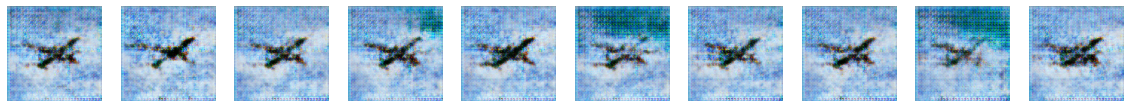

 1001/5000:  0 c, Gen_loss:   11.6015, Disc_loss:    0.2029
 1002/5000:  0 c, Gen_loss:   13.1332, Disc_loss:    0.0046
 1003/5000:  0 c, Gen_loss:   13.2406, Disc_loss:    0.0282
 1004/5000:  0 c, Gen_loss:   12.8538, Disc_loss:    0.0062
 1005/5000:  0 c, Gen_loss:   13.0058, Disc_loss:    0.0053
 1006/5000:  0 c, Gen_loss:   14.5670, Disc_loss:    0.1103
 1007/5000:  0 c, Gen_loss:   13.4618, Disc_loss:    0.0129
 1008/5000:  0 c, Gen_loss:   15.2042, Disc_loss:    0.1169
 1009/5000:  0 c, Gen_loss:   12.9611, Disc_loss:    0.0041
 1010/5000:  0 c, Gen_loss:   11.5126, Disc_loss:    0.0694
 1011/5000:  0 c, Gen_loss:   10.4230, Disc_loss:    0.0143
 1012/5000:  0 c, Gen_loss:   10.3509, Disc_loss:    0.0082
 1013/5000:  0 c, Gen_loss:   11.1274, Disc_loss:    0.0403
 1014/5000:  0 c, Gen_loss:   11.0679, Disc_loss:    0.1601
 1015/5000:  0 c, Gen_loss:   10.8506, Disc_loss:    0.0015
 1016/5000:  0 c, Gen_loss:   10.9704, Disc_loss:    0.0436
 1017/5000:  0 c, Gen_loss:   13.8909, D

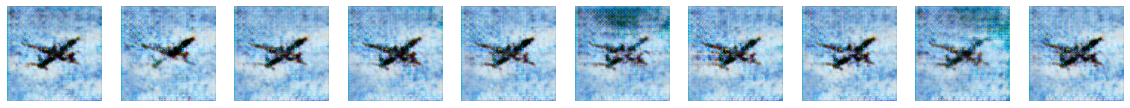

 2001/5000:  0 c, Gen_loss:   11.3904, Disc_loss:    0.0076
 2002/5000:  0 c, Gen_loss:   12.3543, Disc_loss:    0.0086
 2003/5000:  0 c, Gen_loss:    9.2345, Disc_loss:    0.1099
 2004/5000:  0 c, Gen_loss:   11.8072, Disc_loss:    0.0712
 2005/5000:  0 c, Gen_loss:   10.6063, Disc_loss:    0.0208
 2006/5000:  0 c, Gen_loss:   11.5979, Disc_loss:    0.0366
 2007/5000:  0 c, Gen_loss:   10.8780, Disc_loss:    0.0293
 2008/5000:  0 c, Gen_loss:   12.0751, Disc_loss:    0.0145
 2009/5000:  0 c, Gen_loss:   11.1713, Disc_loss:    0.0077
 2010/5000:  0 c, Gen_loss:    9.9537, Disc_loss:    0.0808
 2011/5000:  0 c, Gen_loss:    8.5955, Disc_loss:    0.0909
 2012/5000:  0 c, Gen_loss:    9.4512, Disc_loss:    0.0045
 2013/5000:  0 c, Gen_loss:   10.0034, Disc_loss:    0.0037
 2014/5000:  0 c, Gen_loss:    8.2316, Disc_loss:    0.0282
 2015/5000:  0 c, Gen_loss:    9.2740, Disc_loss:    0.0492
 2016/5000:  0 c, Gen_loss:    9.4795, Disc_loss:    0.0547
 2017/5000:  0 c, Gen_loss:    7.7460, D

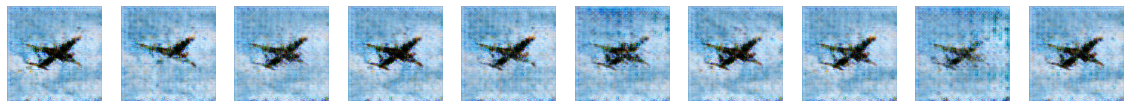

In [177]:
print(imgs.shape, labels.shape)
history = train(imgs, labels, 5000)

# Выводим график

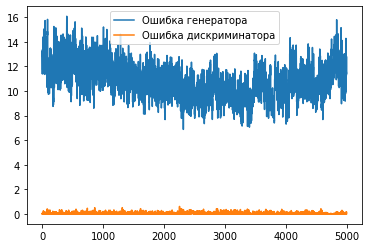

In [178]:
  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания
  plt.plot(history[:, 0], label="Ошибка генератора")
  plt.plot(history[:, 1], label="Ошибка дискриминатора")
  plt.legend()
  plt.show()

## Выводим 10 изображений лейблов

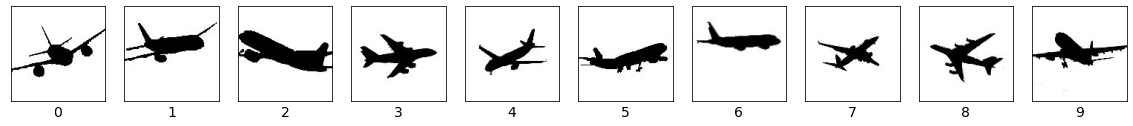

In [179]:
plot_images(labels[0:10])

# Выводим 10 сгенерированных изображений на констатном шуме

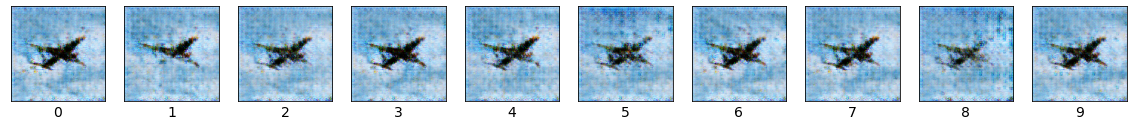

In [180]:
gen_imgs = generator.predict([NOISE_CONST, labels[0:10]])

plot_images(gen_imgs)

## Сгенерируем новый шум и сравним изображения

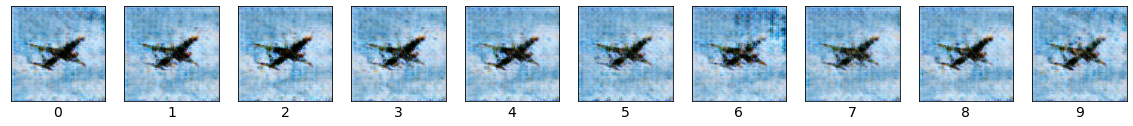

In [181]:
noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
gen_imgs = generator.predict([noise, labels[0:10]])

plot_images(gen_imgs)

## Ещё 10 сгенерированных

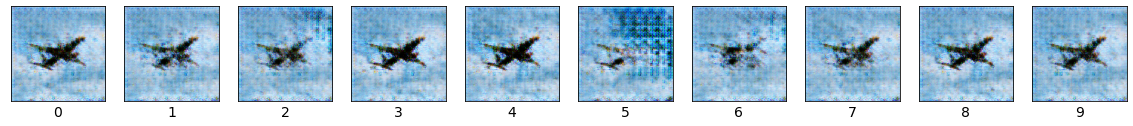

In [182]:
noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
gen_imgs = generator.predict([noise, labels[0:10]])

plot_images(gen_imgs)